In [1]:
from __future__ import division, print_function
import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
from importlib import reload  # Python 3
import utils; reload(utils)
from utils import plots

import time
from utils import pred_batch
from utils import plots
from utils import confusion_matrix
from utils import plot_confusion_matrix

from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom
from sklearn.metrics import confusion_matrix
import itertools
from itertools import chain


import warnings

from keras.models import Model
from keras import layers
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.engine.topology import get_source_inputs
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.preprocessing import image


from keras.optimizers import SGD, RMSprop, Adam
%matplotlib inline

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 970 (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5110)
Using Theano backend.


# Define paths and constants

In [2]:
#path to sample data aranged in train, valid and test folders
path='C:\\Users\\U5752631\\Desktop\\csproj17s2\\artefacts\\data\\machinelearning\\sample\\'

#if orignal weights not found in ~/keras/models/ then download them from following url
WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/inception_v3_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

weight_path = 'C:\\Users\\U5752631\\Desktop\\csproj17s2\\artefacts\data\\pretrained_models\\parkinglot_inception_v3'
weight_name='parkinglot_inception_v3'
#load orignal weights
weight_path = 'C:\\Users\\U5752631\\.keras\\models\\inception_v3_weights_tf_dim_ordering_tf_kernels.h5'

results_path='C:\\Users\\U5752631\\Desktop\\csproj17s2\\artefacts\\data\\pretrained_models\\inception_v3\\'

batch_size = 16
if not os.path.exists(results_path):
    os.makedirs(results_path)

In [3]:
#defin convlution batch normaliztion block
def conv2d_bn(x,
              filters,
              num_row,
              num_col,
              padding='same',
              strides=(1, 1),
              name=None):
    """Utility function to apply conv + BN.

    Arguments:
        x: input tensor.
        filters: filters in `Conv2D`.
        num_row: height of the convolution kernel.
        num_col: width of the convolution kernel.
        padding: padding mode in `Conv2D`.
        strides: strides in `Conv2D`.
        name: name of the ops; will become `name + '_conv'`
            for the convolution and `name + '_bn'` for the
            batch norm layer.

    Returns:
        Output tensor after applying `Conv2D` and `BatchNormalization`.
    """
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    if K.image_data_format() == 'channels_first':
        bn_axis = 1
    else:
        bn_axis = 3
    x = Conv2D(
        filters, (num_row, num_col),
        strides=strides,
        padding=padding,
        use_bias=False,
        name=conv_name)(x)
    x = BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
    x = Activation('relu', name=name)(x)
    return x


In [4]:
#InceptionV3 model architecture 
def InceptionV3(include_top=True,
                weights='imagenet',
                input_tensor=None,
                input_shape=None,
                pooling=None,
                classes=1000):
    """Instantiates the Inception v3 architecture.

    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    Note that the default input image size for this model is 299x299.

    Arguments:
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(299, 299, 3)` (with `channels_last` data format)
            or `(3, 299, 299)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 139.
            E.g. `(150, 150, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.

    Returns:
        A Keras model instance.

    Raises:
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = _obtain_input_shape(
        input_shape,
        default_size=299,
        min_size=139,
        data_format=K.image_data_format(),
        include_top=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        img_input = Input(tensor=input_tensor, shape=input_shape)

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3

    x = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid')
    x = conv2d_bn(x, 32, 3, 3, padding='valid')
    x = conv2d_bn(x, 64, 3, 3)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv2d_bn(x, 80, 1, 1, padding='valid')
    x = conv2d_bn(x, 192, 3, 3, padding='valid')
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # mixed 0, 1, 2: 35 x 35 x 256
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 32, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed0')

    # mixed 1: 35 x 35 x 256
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed1')

    # mixed 2: 35 x 35 x 256
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed2')

    # mixed 3: 17 x 17 x 768
    branch3x3 = conv2d_bn(x, 384, 3, 3, strides=(2, 2), padding='valid')

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(
        branch3x3dbl, 96, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = layers.concatenate(
        [branch3x3, branch3x3dbl, branch_pool], axis=channel_axis, name='mixed3')

    # mixed 4: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 128, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 128, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch7x7, branch7x7dbl, branch_pool],
        axis=channel_axis,
        name='mixed4')

    # mixed 5, 6: 17 x 17 x 768
    for i in range(2):
        branch1x1 = conv2d_bn(x, 192, 1, 1)

        branch7x7 = conv2d_bn(x, 160, 1, 1)
        branch7x7 = conv2d_bn(branch7x7, 160, 1, 7)
        branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

        branch7x7dbl = conv2d_bn(x, 160, 1, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 1, 7)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

        branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate(
            [branch1x1, branch7x7, branch7x7dbl, branch_pool],
            axis=channel_axis,
            name='mixed' + str(5 + i))

    # mixed 7: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 192, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 192, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 192, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch7x7, branch7x7dbl, branch_pool],
        axis=channel_axis,
        name='mixed7')

    # mixed 8: 8 x 8 x 1280
    branch3x3 = conv2d_bn(x, 192, 1, 1)
    branch3x3 = conv2d_bn(branch3x3, 320, 3, 3,
                          strides=(2, 2), padding='valid')

    branch7x7x3 = conv2d_bn(x, 192, 1, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
    branch7x7x3 = conv2d_bn(
        branch7x7x3, 192, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = layers.concatenate(
        [branch3x3, branch7x7x3, branch_pool], axis=channel_axis, name='mixed8')

    # mixed 9: 8 x 8 x 2048
    for i in range(2):
        branch1x1 = conv2d_bn(x, 320, 1, 1)

        branch3x3 = conv2d_bn(x, 384, 1, 1)
        branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
        branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
        branch3x3 = layers.concatenate(
            [branch3x3_1, branch3x3_2], axis=channel_axis, name='mixed9_' + str(i))

        branch3x3dbl = conv2d_bn(x, 448, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
        branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
        branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
        branch3x3dbl = layers.concatenate(
            [branch3x3dbl_1, branch3x3dbl_2], axis=channel_axis)

        branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate(
            [branch1x1, branch3x3, branch3x3dbl, branch_pool],
            axis=channel_axis,
            name='mixed' + str(9 + i))
    if include_top:
        # Classification block
        x = GlobalAveragePooling2D(name='avg_pool')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='inception_v3')

    # load weights
    if weights == 'imagenet':
        if K.image_data_format() == 'channels_first':
            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
        if include_top:
            weights_path = get_file(
                'inception_v3_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                md5_hash='9a0d58056eeedaa3f26cb7ebd46da564')
        else:
            weights_path = get_file(
                'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                md5_hash='bcbd6486424b2319ff4ef7d526e38f63')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            convert_all_kernels_in_model(model)
    return model

In [5]:
#create model
model = InceptionV3(include_top=True, weights='imagenet')

In [6]:
#test model
"""
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

img_path = '1.jpg'
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

preds = model.predict(x)
print('Predicted:', decode_predictions(preds))
"""

"\ndef preprocess_input(x):\n    x /= 255.\n    x -= 0.5\n    x *= 2.\n    return x\n\nimg_path = '1.jpg'\nimg = image.load_img(img_path, target_size=(299, 299))\nx = image.img_to_array(img)\nx = np.expand_dims(x, axis=0)\n# x = preprocess_input(x)\nprint('Input image shape:', x.shape)\n\npreds = model.predict(x)\nprint('Predicted:', decode_predictions(preds))\n"

In [7]:
#load orignal weights
#model_path = '~/.keras/models/inception_v3_weights_th_dim_ordering_th_kernels.h5'
#model.load_weights(get_file(weight_name, model_path, cache_subdir='models'))


In [8]:
#get batch but adjust image size to 299x299 like in orignal paper
def get_batches( path, gen=image.ImageDataGenerator(), shuffle=True, batch_size=8, class_mode='categorical'):
    return gen.flow_from_directory(path, target_size=(299,299),
                                   class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [9]:
train_batches = get_batches(path+'train', batch_size=batch_size)
validation_batches = get_batches(path+'valid', batch_size=batch_size*2)

Found 391 images belonging to 2 classes.
Found 105 images belonging to 2 classes.


In [10]:
#fine tune: drop the final layer and add a new layer to match the classes in current dataset and recompile the model
#set learning rate
lr=0.0001

model.layers.pop()
for layer in model.layers: layer.trainable=False
model.layers[-1].outbound_nodes = []
model.outputs = [model.layers[-1].output]
output = model.get_layer('avg_pool').output
output = Dense(train_batches.num_class, activation='softmax',name='new_predictions')(output) 

model = Model(model.input, output)

model.compile(optimizer=Adam(lr=lr),loss='categorical_crossentropy', metrics=['accuracy'])

classes = list(iter(train_batches.class_indices))
for c in train_batches.class_indices:
    classes[train_batches.class_indices[c]] = c

In [11]:
#fit run single epoch
nb_epoch=1
model.optimizer.lr=0.0001
model.fit_generator(train_batches,
                    steps_per_epoch=int(np.ceil(train_batches.samples/batch_size)),
                    epochs=nb_epoch,
                    validation_data=validation_batches, 
                    validation_steps=int(np.ceil(validation_batches.samples/batch_size)))

Epoch 1/1
25/25 [==============================] - 5s - loss: 0.5992 - acc: 0.7417 - val_loss: 0.7136 - val_acc: 0.4677


In [12]:
model.save_weights(results_path+'parkinglot_inceptionv3.h5')

In [13]:
#model.load_weights(results_path+'parkinglot_inceptionv3.h5')

In [14]:
#Notice we are passing in the validation dataset to the fit() method
#For each epoch we test our model against the validation set
#uncomment following code to run multiple epoches and adjust the learning rate
"""
latest_weights_filename = None
model.optimizer.lr = 0.01
no_of_epochs=2
batch_size = 16
for epoch in range(no_of_epochs):
    print("Running epoch: %d" % epoch)
    
    model.fit_generator(batches, steps_per_epoch=int(np.ceil(batches.samples/batch_size)),                    
                        epochs=nb_epoch,validation_data=validation_batches, validation_steps=int(np.ceil(validation_batches.samples/batch_size)))

    
    latest_weights_filename = 'ft%d.h5' % epoch
    model.save_weights(results_path+latest_weights_filename)
print("Completed %s fit operations" % no_of_epochs)
"""

'\nlatest_weights_filename = None\nmodel.optimizer.lr = 0.01\nno_of_epochs=2\nbatch_size = 16\nfor epoch in range(no_of_epochs):\n    print("Running epoch: %d" % epoch)\n    \n    model.fit_generator(batches, steps_per_epoch=int(np.ceil(batches.samples/batch_size)),                    \n                        epochs=nb_epoch,validation_data=validation_batches, validation_steps=int(np.ceil(validation_batches.samples/batch_size)))\n\n    \n    latest_weights_filename = \'ft%d.h5\' % epoch\n    model.save_weights(results_path+latest_weights_filename)\nprint("Completed %s fit operations" % no_of_epochs)\n'

Found 391 images belonging to 2 classes.


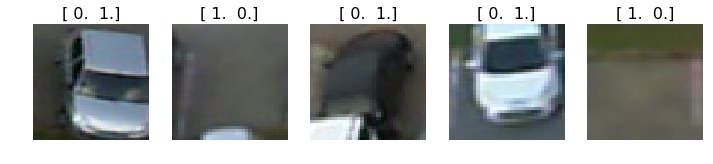

In [15]:
#sample batch data
batch_size = 5
batches = get_batches(path+'train', batch_size=batch_size)
imgs,labels = next(batches)
plots(imgs, titles=labels)

In [16]:
#predictions sample batch data
pred_batch(model,classes,imgs)

Shape: (5, 2)
Classes: ['empty', 'occupied']
Probabilities: [ 0.2513  0.7487]

Predictions prob/class: 
  0.7487/occupied
  0.7026/occupied
  0.5935/occupied
  0.5636/occupied
  0.5265/occupied


In [17]:
#finding predictions for sample test data
#Note: this takes average time = no of test images*0.01secs
start_time = time.time()
print(start_time)
#get the test batches and remove class label
test_batches = get_batches(path+'test', shuffle=False, batch_size=batch_size, class_mode=None)
#generate the probobailty of belonging to a class
val_batches, probs = test_batches, model.predict_generator(test_batches, int(np.ceil(test_batches.samples/batch_size)))
print((time.time() - start_time),'s')

1509272441.9200673
Found 40 images belonging to 2 classes.
0.6911532878875732 s


In [18]:
print("time per image" , ((time.time() - start_time)/len(probs)))

time per image 0.017477011680603026


[[ 6 14]
 [ 0 20]]
error:  35.0


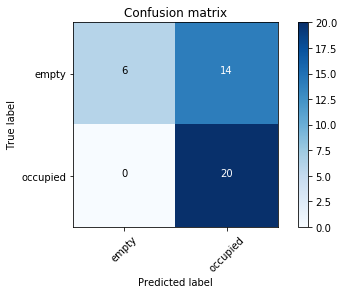

In [19]:
#computing confustion matrix

our_predictions = probs[:,0]
our_labels = np.round(1-our_predictions)

expected_labels = val_batches.classes

cm = confusion_matrix(expected_labels, our_labels)
plot_confusion_matrix(cm, val_batches.class_indices)

In [20]:
model.summary() 

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 299, 299)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 32, 149, 149)  864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 32, 149, 149)  96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 32, 149, 149)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

conv2d_17 (Conv2D)               (None, 96, 35, 35)    55296       activation_16[0][0]              
____________________________________________________________________________________________________
batch_normalization_14 (BatchNor (None, 48, 35, 35)    144         conv2d_14[0][0]                  
____________________________________________________________________________________________________
batch_normalization_17 (BatchNor (None, 96, 35, 35)    288         conv2d_17[0][0]                  
____________________________________________________________________________________________________
activation_14 (Activation)       (None, 48, 35, 35)    0           batch_normalization_14[0][0]     
____________________________________________________________________________________________________
activation_17 (Activation)       (None, 96, 35, 35)    0           batch_normalization_17[0][0]     
___________________________________________________________________________________________

batch_normalization_29 (BatchNor (None, 96, 35, 35)    288         conv2d_29[0][0]                  
____________________________________________________________________________________________________
activation_29 (Activation)       (None, 96, 35, 35)    0           batch_normalization_29[0][0]     
____________________________________________________________________________________________________
conv2d_27 (Conv2D)               (None, 384, 17, 17)   995328      mixed2[0][0]                     
____________________________________________________________________________________________________
conv2d_30 (Conv2D)               (None, 96, 17, 17)    82944       activation_29[0][0]              
____________________________________________________________________________________________________
batch_normalization_27 (BatchNor (None, 384, 17, 17)   1152        conv2d_27[0][0]                  
___________________________________________________________________________________________

conv2d_46 (Conv2D)               (None, 160, 17, 17)   179200      activation_45[0][0]              
____________________________________________________________________________________________________
batch_normalization_46 (BatchNor (None, 160, 17, 17)   480         conv2d_46[0][0]                  
____________________________________________________________________________________________________
activation_46 (Activation)       (None, 160, 17, 17)   0           batch_normalization_46[0][0]     
____________________________________________________________________________________________________
conv2d_42 (Conv2D)               (None, 160, 17, 17)   122880      mixed4[0][0]                     
____________________________________________________________________________________________________
conv2d_47 (Conv2D)               (None, 160, 17, 17)   179200      activation_46[0][0]              
___________________________________________________________________________________________

conv2d_58 (Conv2D)               (None, 160, 17, 17)   179200      activation_57[0][0]              
____________________________________________________________________________________________________
batch_normalization_53 (BatchNor (None, 160, 17, 17)   480         conv2d_53[0][0]                  
____________________________________________________________________________________________________
batch_normalization_58 (BatchNor (None, 160, 17, 17)   480         conv2d_58[0][0]                  
____________________________________________________________________________________________________
activation_53 (Activation)       (None, 160, 17, 17)   0           batch_normalization_53[0][0]     
____________________________________________________________________________________________________
activation_58 (Activation)       (None, 160, 17, 17)   0           batch_normalization_58[0][0]     
___________________________________________________________________________________________

batch_normalization_61 (BatchNor (None, 192, 17, 17)   576         conv2d_61[0][0]                  
____________________________________________________________________________________________________
batch_normalization_64 (BatchNor (None, 192, 17, 17)   576         conv2d_64[0][0]                  
____________________________________________________________________________________________________
batch_normalization_69 (BatchNor (None, 192, 17, 17)   576         conv2d_69[0][0]                  
____________________________________________________________________________________________________
batch_normalization_70 (BatchNor (None, 192, 17, 17)   576         conv2d_70[0][0]                  
____________________________________________________________________________________________________
activation_61 (Activation)       (None, 192, 17, 17)   0           batch_normalization_61[0][0]     
___________________________________________________________________________________________

conv2d_84 (Conv2D)               (None, 384, 8, 8)     442368      activation_82[0][0]              
____________________________________________________________________________________________________
average_pooling2d_8 (AveragePool (None, 1280, 8, 8)    0           mixed8[0][0]                     
____________________________________________________________________________________________________
conv2d_77 (Conv2D)               (None, 320, 8, 8)     409600      mixed8[0][0]                     
____________________________________________________________________________________________________
batch_normalization_79 (BatchNor (None, 384, 8, 8)     1152        conv2d_79[0][0]                  
____________________________________________________________________________________________________
batch_normalization_80 (BatchNor (None, 384, 8, 8)     1152        conv2d_80[0][0]                  
___________________________________________________________________________________________

Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
____________________________________________________________________________________________________


In [21]:
#code to beep when code ends
"""
import winsound
frequency = 200  # Set Frequency To 2500 Hertz
duration = 500  # Set Duration To 1000 ms == 1 second
winsound.Be
"""

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-21-cdca577b1fa3>, line 6)

In [ ]:
#weight paths
'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels.h5'
'https://github.com/fchollet/deep-learning-models/releases/download/v0.4/xception_weights_tf_dim_ordering_tf_kernels.h5'
'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
#Inception-v4
'https://github.com/fchollet/deep-learning-models/releases/download/v0.7/'
'https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels.h5'

In [ ]:
# -*- coding: utf-8 -*-
# Reference:
"""
Szegedy C, Vanhoucke V, Ioffe S, Shlens J, Wojna Z. Rethinking the inception architecture for computer vision. InProceedings of the IEEE Conference on Computer Vision and Pattern Recognition 2016 (pp. 2818-2826).
Adapted from code contributed by BigMoyan.
François Chollet, https://github.com/fchollet/deep-learning-models
'''